In [1]:
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/cleaning.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/data_loader.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/extractNet_connected.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/extractNet_connected_v2.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/extractNet_connected_vgg.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/extractNet_simple.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/helper.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/metrics.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/trainer.py
!wget https://github.com/MNRKhan/aps360-project/raw/master/modules/visualizer.py

--2019-03-22 19:34:38--  https://github.com/MNRKhan/aps360-project/raw/master/modules/cleaning.py
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MNRKhan/aps360-project/master/modules/cleaning.py [following]
--2019-03-22 19:34:38--  https://raw.githubusercontent.com/MNRKhan/aps360-project/master/modules/cleaning.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8197 (8.0K) [text/plain]
Saving to: ‘cleaning.py’

cleaning.py         100%[===================>]   8.00K  --.-KB/s    in 0s      

2019-03-22 19:34:38 (81.9 MB/s) - ‘cleaning.py’ saved [8197/8197]

--2019-03-22 19:34:39--

In [0]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from helper import getModelName
from cleaning import load_data, get_dictionaries, resize, resize_square, get_dataloader, get_prominent_mask
from visualizer import imshow, getBitMask, getMaskedImg, tensorToNpImg, thresholdProbMask, extractProminent, plotCurve, plotPerformance
from metrics import getPercentMask, calculateIoU, calculateTotalIoU, getLoss
from extractNet_simple import extractNet_simple
from extractNet_connected import extractNet_connected
from extractNet_connected_vgg19 import extractNet_connected_vgg19
from trainer import trainModel
from data_loader import ImageMaskDataset

In [0]:
!rm -rf __MACOSX
!rm -rf *.zip

In [4]:
!wget https://github.com/MNRKhan/aps360-project/raw/master/datasets/data_vehicle.zip

--2019-03-22 19:34:52--  https://github.com/MNRKhan/aps360-project/raw/master/datasets/data_vehicle.zip
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MNRKhan/aps360-project/master/datasets/data_vehicle.zip [following]
--2019-03-22 19:34:53--  https://raw.githubusercontent.com/MNRKhan/aps360-project/master/datasets/data_vehicle.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3815765 (3.6M) [application/zip]
Saving to: ‘data_vehicle.zip’

data_vehicle.zip    100%[===================>]   3.64M  --.-KB/s    in 0.1s    

2019-03-22 19:34:53 (34.8 MB/s) - ‘data_vehicle.zip’ saved 

In [5]:
!unzip data_vehicle.zip

Archive:  data_vehicle.zip
   creating: data/
   creating: data/images/
  inflating: data/images/63.jpg      
  inflating: data/images/189.jpg     
  inflating: data/images/77.jpg      
  inflating: data/images/162.jpg     
  inflating: data/images/176.jpg     
  inflating: data/images/88.jpg      
  inflating: data/images/228.jpg     
  inflating: data/images/214.jpg     
  inflating: data/images/200.jpg     
  inflating: data/images/201.jpg     
  inflating: data/images/215.jpg     
  inflating: data/images/229.jpg     
  inflating: data/images/177.jpg     
  inflating: data/images/89.jpg      
  inflating: data/images/163.jpg     
  inflating: data/images/188.jpg     
  inflating: data/images/76.jpg      
  inflating: data/images/62.jpg      
  inflating: data/images/74.jpg      
  inflating: data/images/60.jpg      
  inflating: data/images/48.jpg      
  inflating: data/images/149.jpg     
  inflating: data/images/175.jpg     
  inflating: data/images/161.jpg     
  inflating: dat

In [0]:
!rm -rf __MACOSX
!rm -rf *.zip

In [0]:
batch_size = 16
lr = 0.005

In [0]:
# Set random seeds

torch.manual_seed(360)
np.random.seed(360)
random.seed(360)

# Form dataset

transform = transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = ImageMaskDataset("/content/data", transform)

# Dataset sizes

size = len(dataset)
   
train_size = int(0.6 * size)
valid_size = int(0.2 * size)
test_size = size - train_size - valid_size

# Splitting datasets
  
train_data, valid_data, test_data = torch.utils.data.random_split(dataset, [train_size, valid_size, test_size])

# Making dataloader

train = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
valid = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = extractNet_connected_vgg19()
net.to(device)

print("Model is being trained on:", device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:07, 75456326.24it/s]


Model is being trained on: cuda:0


Epoch:0, Train IoU:0.3209, Train Loss:0.0496|Valid IoU:0.3147, Valid Loss:0.0458
Epoch:1, Train IoU:0.3535, Train Loss:0.0491|Valid IoU:0.3421, Valid Loss:0.0455
Epoch:2, Train IoU:0.3491, Train Loss:0.0470|Valid IoU:0.3299, Valid Loss:0.0436
Epoch:3, Train IoU:0.4243, Train Loss:0.0462|Valid IoU:0.4010, Valid Loss:0.0432
Epoch:4, Train IoU:0.4362, Train Loss:0.0458|Valid IoU:0.4099, Valid Loss:0.0432
Epoch:5, Train IoU:0.4391, Train Loss:0.0446|Valid IoU:0.4073, Valid Loss:0.0421
Epoch:6, Train IoU:0.4585, Train Loss:0.0452|Valid IoU:0.4273, Valid Loss:0.0423
Epoch:7, Train IoU:0.5028, Train Loss:0.0459|Valid IoU:0.4692, Valid Loss:0.0433
Epoch:8, Train IoU:0.4995, Train Loss:0.0441|Valid IoU:0.4610, Valid Loss:0.0419
Epoch:9, Train IoU:0.5346, Train Loss:0.0443|Valid IoU:0.4898, Valid Loss:0.0418
Training Finished
Total time elapsed: 187.78 seconds

Final Training IoU: 0.5346132451540804

Best Validation IoU: 0.4897630413373311
On at epoch: 9


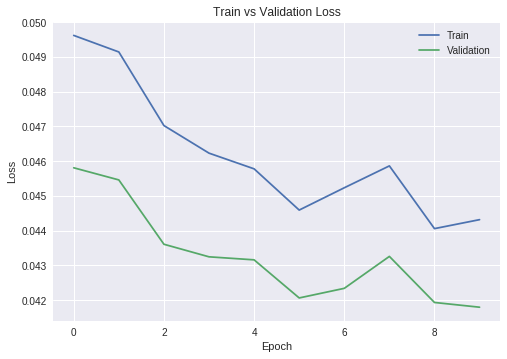

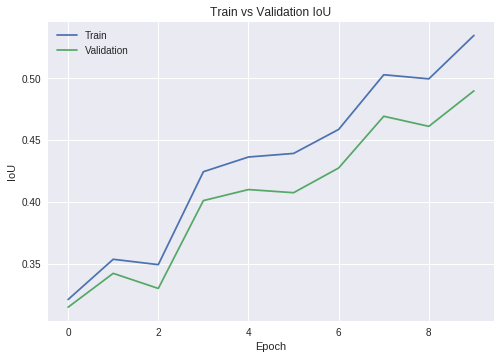

In [19]:
trainModel(net, train, valid, batch_size=batch_size, lr=lr, num_epochs=10, checkpoint=False, device=device)

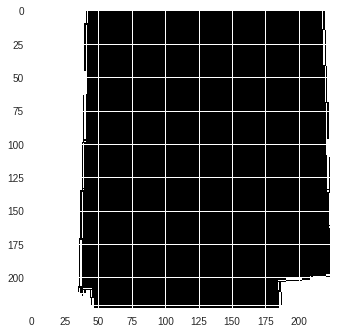

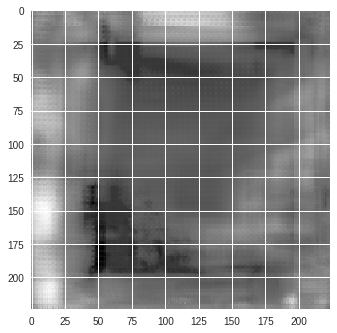

In [0]:
# After training
img, target = valid_data[0]
out = net(img.unsqueeze(0))

target = target.squeeze(0).detach().numpy()
out = out.squeeze(0).squeeze(0).detach().numpy()

plt.imshow(target)
plt.show()
plt.imshow(out)

In [0]:
torch.cuda.is_available()

True

In [0]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
!nvidia-smi

Fri Mar 22 00:50:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    31W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  